In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from torchvision import models
from torchvision import transforms
import os

In [2]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised" or os.path.split(os.getcwd())[1] == "clustering"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [3]:
model = models.resnet50()
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("C:\\Users\\marco\\Desktop\\Uni\\Magistrale\\VIPM\\Progetto\\resnet50model.pth")['model_state'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.feature_extractor = nn.Sequential(*list(model.children())[:-2])  # Extract features from layer 4

    def forward(self, x):
        with torch.no_grad():
            features = self.feature_extractor(x)
        return features.squeeze()

In [5]:
feature_extractor = FeatureExtractor(model)
feature_extractor.to(device)
feature_extractor.eval()

FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [6]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor([0.6354, 0.5413, 0.4419]), std=torch.tensor([0.2760, 0.2900, 0.3161]))
])

In [7]:
from PIL import Image

def preprocess_image(image_path):
    """Load and preprocess an image."""
    img = Image.open(image_path).convert("RGB")
    return preprocess(img).unsqueeze(0)

def extract_features(image_paths):
    """Extract features for a list of image paths."""
    features = []
    for img_path in tqdm(image_paths, desc="Extracting features"):
        img_tensor = preprocess_image(img_path)
        img_tensor = img_tensor.to(device)
        feature = feature_extractor(img_tensor).cpu().numpy()
        features.append(feature)
    return np.array(features)


def load_image_paths_and_labels(csv_file):
    """Load image paths and labels from a CSV file."""
    df = pd.read_csv(csv_file, header=None)
    image_paths = [os.path.join(DATA_DIR, img_name) for img_name in df.iloc[:, 0]]
    labels = df.iloc[:, 1].tolist()
    return image_paths, labels

In [8]:
from sklearn.cluster import KMeans
from torch import cosine_similarity


def cluster_images(features, n_clusters):
    """Cluster images using KMeans."""
    clustering_model = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clustering_model.fit_predict(features)
    return clustering_model, cluster_labels


In [9]:
LABEL_THRESHOLD = 0.8
DATA_DIR = "./train_set"
LABELED_CSV = "./train_small.csv"
UNLABELED_CSV = "./train_unlabeled.csv"
OUTPUT_CSV = "./augmented_labels.csv"

In [18]:
labeled_image_paths, labeled_labels = load_image_paths_and_labels(LABELED_CSV)
unlabeled_image_paths, unlabeled_labels = load_image_paths_and_labels(UNLABELED_CSV)

In [11]:
# Use only 20% of the unlabeled dataset
unlabeled_sample_size = int(0.2 * len(unlabeled_image_paths))
unlabeled_image_paths = np.random.choice(unlabeled_image_paths, unlabeled_sample_size, replace=False).tolist()

In [12]:
labeled_features = extract_features(labeled_image_paths)
unlabeled_features = extract_features(unlabeled_image_paths)

Extracting features: 100%|██████████| 22691/22691 [04:02<00:00, 93.76it/s]


In [17]:
labeled_features = labeled_features.reshape(labeled_features.shape[0], -1)
unlabeled_features = unlabeled_features.reshape(unlabeled_features.shape[0], -1)

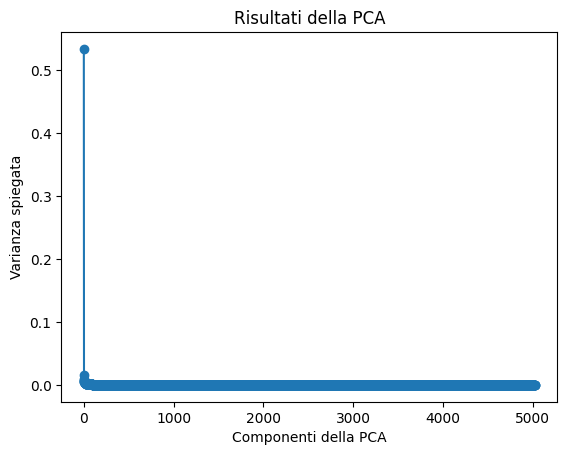

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(labeled_features)
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()

In [20]:
pca = PCA(n_components=100, random_state=42)
labeled_features_reduced = pca.fit_transform(labeled_features)
unlabeled_features_reduced = pca.transform(unlabeled_features)

In [22]:
np.save("labeled_features_reduced.npy", labeled_features_reduced)
np.save("labeled_labels.npy", labeled_labels)
np.save("unlabeled_features_reduced.npy", unlabeled_features_reduced)

In [10]:
labeled_features_reduced = np.load("labeled_features_reduced.npy")
labeled_labels = np.load("labeled_labels.npy")
unlabeled_features_reduced = np.load("unlabeled_features_reduced.npy")

In [12]:
kmeans = KMeans(n_clusters=251, random_state=42)
kmeans.fit(np.vstack([labeled_features_reduced, unlabeled_features_reduced]))

KMeans(n_clusters=251, random_state=42)

In [13]:
labeled_cluster_labels = kmeans.labels_[:len(labeled_features_reduced)]
unlabeled_cluster_labels = kmeans.labels_[len(labeled_features_reduced):]

In [14]:
cluster_labels = {}
# Trova la label di maggioranza per ogni cluster
for cluster_id in np.unique(labeled_cluster_labels):
    # Indici degli esempi appartenenti al cluster
    cluster_indices = np.where(labeled_cluster_labels == cluster_id)[0]
    # Etichetta di maggioranza
    majority_label = np.bincount(labeled_labels[cluster_indices]).argmax()
    # Assegna l'etichetta al cluster
    cluster_labels[cluster_id] = majority_label


In [22]:
print(np.unique(labeled_cluster_labels))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 236 237 238 239 240 241 242 243 244 245 246 24

In [ ]:
from sklearn.metrics import euclidean_distances
# Testo per diverse percentuali di confidenza
x = [10,20,50]
for x in x:
    top_x_percent_data = []
    # Per ogni cluster labelato seleziona gli x% dati non labelati più vicini al centroide e assegna loro la label del cluster
    for cluster_id in np.unique(unlabeled_cluster_labels):
        #Controlla che il cluster abbia almeno un dato labelato
        if cluster_id not in cluster_labels:
            print(f"Nessun dato labelato per cluster {cluster_id}")
            continue
        #Estraggo gli indici degli esempi appartenenti al cluster
        cluster_indices = np.where(unlabeled_cluster_labels == cluster_id)[0]
        centroids = kmeans.cluster_centers_[cluster_id]
        #Estraggo i dati del cluster 
        cluster_data = unlabeled_features_reduced[cluster_indices]
        #Calcolo le distanze euclidee tra i centroidi e i dati del cluster
        distances = euclidean_distances(cluster_data, centroids.reshape(1, -1))
        #Ordino le distanze
        sorted_indices = np.argsort(distances.flatten())
        #Seleziono gli x% dati più vicini al centroide
        top_x_count = int(len(sorted_indices) * x/100)
        top_x_indices = sorted_indices[:top_x_count]
        assigned_labels = cluster_labels[cluster_id]
        #Aggiungo i dati selezionati alla lista
        for idx in top_x_indices:
            top_x_percent_data.append((unlabeled_image_paths[cluster_indices[idx]], assigned_labels))
    #Salvo i dati in un file csv
    top_x_df = pd.DataFrame(top_x_percent_data)
    top_x_df.to_csv(f'top_{x}_assigned_labels.csv', index=False)

Nessun dato labelato per cluster 235
Nessun dato labelato per cluster 235
Nessun dato labelato per cluster 235
